### - Sobhan Moradian Daghigh
#### - 6/29/2022
### - DIP - HW04 - Q2

In [1]:
import numpy as np
import glob
import cv2
from matplotlib import pyplot as plt
from skimage.restoration import denoise_tv_chambolle

In [2]:
def load_datas(folder_name):
    images = glob.glob('{}*.png'.format(folder_name))
    datas = []
    names = []
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        datas.append(img)
        names.append(image.split('\\')[-1][:-4])
    return datas, names

In [88]:
images, names = load_datas('./inputs/P2/')

In [89]:
names

['Screenshot 2022-07-06 194649',
 'wait_for_me_daddy_gt',
 'wait_for_me_daddy_lr',
 'wait_for_me_daddy_[+0.1,-0.5]',
 'wait_for_me_daddy_[+0.6,+0.2]',
 'wait_for_me_daddy_[-0.2,-0.3]',
 'wait_for_me_daddy_[-0.3,+0.4]']

In [73]:
def plotter(images, names=None, subplots=None, gray=False):
    if subplots is None:
        plt.figure(figsize=(5, 6))
        plt.imshow(images, cmap='gray') if gray else plt.imshow(images)
        plt.title(names)
        plt.axis('off')
    else:
        fig, ax = plt.subplots(subplots[0], subplots[1], figsize=(subplots[1] * 5, subplots[0] * 6))
        for i, (img, name, ax) in enumerate(zip(images, names, fig.axes)):
            ax.imshow(img, cmap='gray') if gray else ax.imshow(img)
            ax.set_title(name)
            ax.axis('off')
    plt.show()

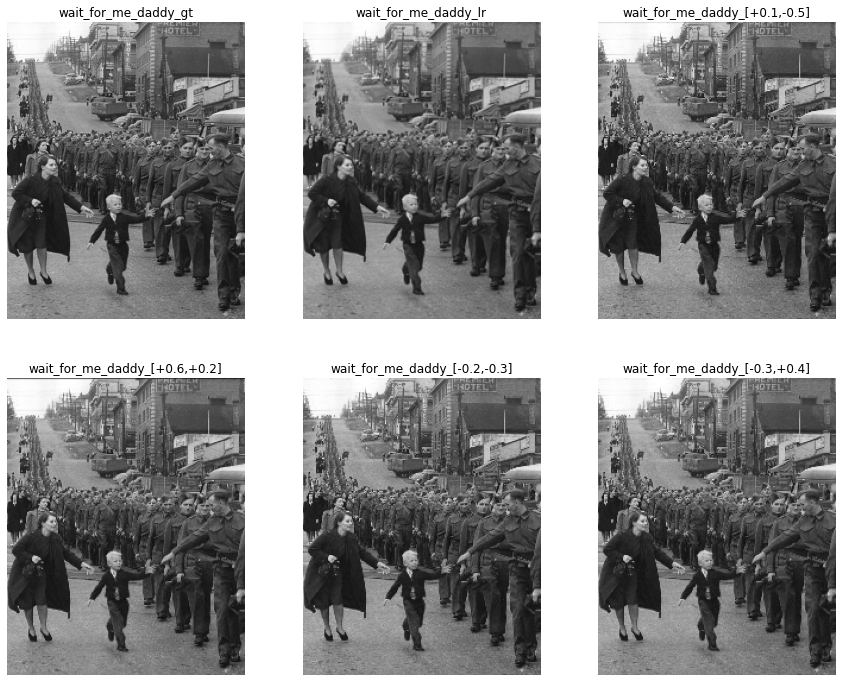

In [90]:
plotter(images[1:], names[1:], subplots=(2, 3))

### Part A.
Nearest-neighbor interpolation

In [186]:
def nearest(img, factor=2):
    h, w = img.shape[:2]
    nh, nw = h * factor, w * factor
    blank = np.zeros((nh, nw, img.shape[2]), dtype=np.uint8)

    for i in range(nh):
        for j in range(nw):
            row    = int(np.floor(i / factor))
            column = int(np.floor(j / factor))

            blank[i, j] = img[row, column]
    return blank

### Part B.
Bilinear interpolation

In [187]:
def bilinear(img, factor=2):
    h, w, channel = img.shape
    nh, nw = h * factor, w * factor

    scale = 1 / factor

    blank = np.zeros((nh, nw, img.shape[2]), dtype=np.uint8)

    for k in range(channel):
        for i in range(nh):
            for j in range(nw):
                x = (j+0.5) * (scale) - 0.5
                y = (i+0.5) * (scale) - 0.5

                x_int = int(x)
                y_int = int(y)

                x_int = min(x_int, w - 2)
                y_int = min(y_int, h - 2)

                x_diff = x - x_int
                y_diff = y - y_int

                a = img[y_int, x_int, k]
                b = img[y_int, x_int + 1, k]
                c = img[y_int + 1, x_int, k]
                d = img[y_int + 1, x_int + 1, k]

                pixel = a * (1 - x_diff) * (1 - y_diff) + \
                        b * (x_diff)     * (1 - y_diff) + \
                        c * (1 - x_diff) * (y_diff) + \
                        d * (x_diff)     * (y_diff)

                blank[i, j, k] = pixel.astype(np.uint8)

    return blank

### Part C.
Nearest_neighbor value interpolation

In [84]:
def get_nearest_value(pixel, arr):
    minimum = 255
    idx = 0
    for i in range(len(arr)):
        value = np.abs(arr[i] - pixel)
        if value < minimum:
            minimum = value
            idx = i
    return arr[idx]

In [188]:
def nearest_neighbor_value(img, factor=2):
    h, w, channel = img.shape
    nh, nw = h * factor, w * factor

    scale = 1 / factor

    blank = np.zeros((nh, nw, img.shape[2]), dtype=np.uint8)

    for k in range(channel):
        for i in range(nh):
            for j in range(nw):
                x = (j+0.5) * (scale) - 0.5
                y = (i+0.5) * (scale) - 0.5

                x_int = int(x)
                y_int = int(y)

                x_int = min(x_int, w - 2)
                y_int = min(y_int, h - 2)

                x_diff = x - x_int
                y_diff = y - y_int

                a = img[y_int, x_int, k]
                b = img[y_int, x_int + 1, k]
                c = img[y_int + 1, x_int, k]
                d = img[y_int + 1, x_int + 1, k]

                pixel = a * (1 - x_diff) * (1 - y_diff) + \
                        b * (x_diff)     * (1 - y_diff) + \
                        c * (1 - x_diff) * (y_diff) + \
                        d * (x_diff)     * (y_diff)
                
                value = get_nearest_value(pixel, [a, b, c, d])

                blank[i, j, k] = value.astype(np.uint8)

    return blank

### Part D.
Non_uniform interpolation

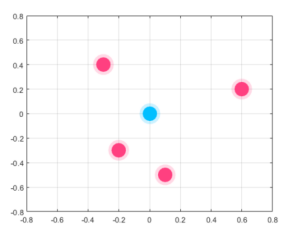

In [91]:
plotter(images[0])

In [189]:
def non_uniform(arr):
    h, w, channel = arr[0].shape
    nh, nw = h * 2, w * 2
    blank = np.zeros((nh, nw, channel), dtype=np.uint8)
    dists = []
    
    dists.append([-0.3, 0.4])
    dists.append([0.6, 0.2])
    dists.append([-0.2, 0.3])
    dists.append([0.1, -0.5])
    
    dists_norm = [np.linalg.norm(ele) for ele in dists]
    
    summation = sum(dists_norm)
    dist_from_all = np.subtract([summation] * 4, dists_norm)
    temp = sum(dist_from_all)
    
    for k in range(channel):
        for i in range(nh):
            for j in range(nw):
                blank[i, j, k] = (arr[0][i // 2, j // 2, k] * dist_from_all[0] + 
                                  arr[1][i // 2, j // 2, k] * dist_from_all[1] + 
                                  arr[2][i // 2, j // 2, k] * dist_from_all[2] + 
                                  arr[3][i // 2, j // 2, k] * dist_from_all[3]) / temp

    return blank

### PSNR

In [162]:
def calculate_psnr(img1, img2, max_value=255):
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    return 100 if mse == 0 else 20 * np.log10(max_value / (np.sqrt(mse)))

### Here we go ))

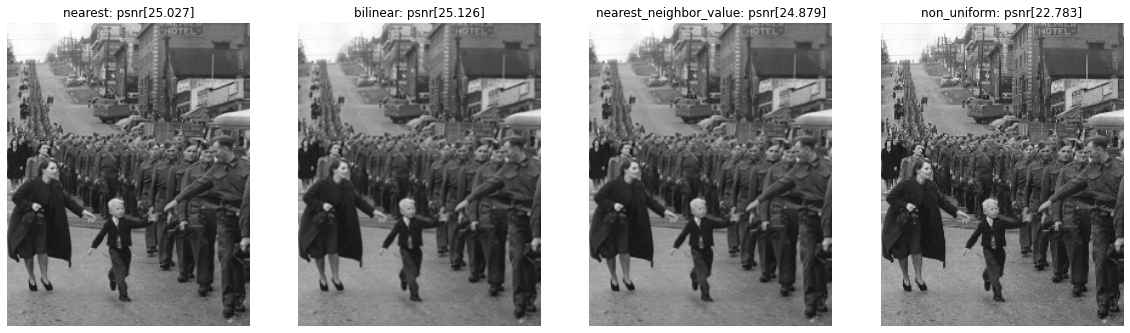

In [193]:
interpolations = [nearest, 
                  bilinear, 
                  nearest_neighbor_value, 
                  non_uniform]

new_imgs = []
psnrs = []
interpolation_names = []
for i, interpolation in enumerate(interpolations):
    ref_img = images[1] # wait_for_me_daddy_gt
    
    if i != 3:
        img = images[2] # wait_for_me_daddy_lr
        new_img = interpolation(img)
        
    else:
        imgs = images[3:]
        new_img = interpolation(imgs)
        
    psnr = calculate_psnr(ref_img, new_img)
    new_imgs.append(new_img)
    interpolation_names.append(str(interpolation).split(' ')[1])
    psnrs.append(psnr)

plot_names = [name + ': psnr[' + str(round(psnr, 3)) + ']' for name, psnr in zip(interpolation_names, psnrs)]
plotter(new_imgs, plot_names, subplots=(1, 4))

### Finito